The goal here is to evaluate the errors introduced adversarial training by a analyzing the added noise

In [265]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, moment
from scipy.interpolate import interp1d

In [266]:
origWeights = np.load('origWeights.npy', allow_pickle=True)
modifiedWeights = np.load('modifiedWeights.npy', allow_pickle=True)
origBiases = np.load('origBiases.npy', allow_pickle=True)
modifiedBiases = np.load('modifiedBiases.npy', allow_pickle=True)

In [267]:
def flatten_listArrays(listArrays):
    flattenedArray = np.array([])
    for array in listArrays:
        flattenedArray = np.append(flattenedArray, array.flatten())
    return flattenedArray

In [268]:
def compute_minAndMax(listArrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    minVal = np.inf
    maxVal = -np.inf
    for arr in listArrays:
        if arr.min() < minVal:
            minVal = arr.min()
        if arr.max() > maxVal:
            maxVal = arr.max()
    return minVal, maxVal

In [269]:
def measure_noise(origValues, modifiedValues):
    noiseValues = []
    for origArr, modifiedArr in zip(origValues, modifiedValues):
        # error_arr is the element-wise difference of all values in the array
        errorArr = origArr - modifiedArr
        noiseValues.append(errorArr)
    return noiseValues

In [270]:
# The CNN for MNIST and the CNN for CIFAR-10, both have convolutional layers followed by a dense layer and then
# a softmax layer. So, the number of conv layers is 2 less than the total number of layers.
numConvLayers = len(origWeights) - 2
modelNoise = measure_noise(origWeights, modifiedWeights)

In [271]:
modelNoise1D = flatten_listArrays(modelNoise)
print(np.std(modelNoise1D))

0.00038695610439112816


In [272]:
def compute_kurtosis(data):
    return moment(data, 4)/(moment(data, 2) ** 2)

In [273]:
# Generate the Gaussian noise for the same number of parameters as contained in the model.
sigmaArray = np.concatenate((np.random.uniform(4e-5, 1e-4,20), np.random.uniform(1e-4, 1e-3,40), 
                             np.random.uniform(1e-3, 4e-3,25), np.random.uniform(4e-3, 1e-2,20)))
sigmaArray.sort()
# print(sigmaArray)
# Remove sigma values that are too small from the array.
indices = []
for idx, val in enumerate(sigmaArray):
    if val <= 1e-5:
        indices.append(idx)
sigmaArray = np.delete(sigmaArray, indices)
for sigma in sigmaArray:
    numParams = len(flatten_listArrays(origWeights))
    randNoise = np.random.normal(0, sigma, numParams)
    b2 = compute_kurtosis(randNoise)

In [274]:
# Compute random noise for all of the layers in the same shape as the neural network weights.
def compute_realNoise(modelNoise, sigma):
    """ Generates real noise consisting of model noise with varying amounts of random noise. The generated noise 
    has the same shape as the input model noise. Both modelNoise and randNoise are expected to have the same 
    length """
    realNoise = []
    randNoiseArray = []
    for modelLayer in modelNoise:
        randLayer = np.random.normal(0,sigma, modelLayer.shape)
        realLayer = modelLayer + randLayer
        realNoise.append(realLayer)
        #randNoiseArray.append(randLayer)
    #variance = np.var(flatten_listArrays(randNoiseArray))
    #print(sigma ** 2, variance)
    return realNoise

variance of model noise : 1.5e-07


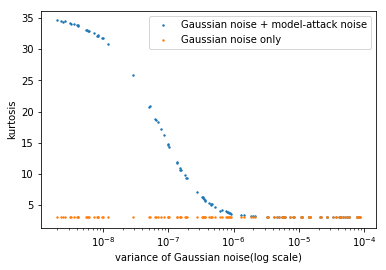

In [275]:
v = np.var(flatten_listArrays(modelNoise))
print('variance of model noise : {0:.3g}'.format(v))
varList = []
b2FNvals = []
for sigma in sigmaArray:
    realNoise = compute_realNoise(modelNoise, sigma)
    realNoise1D = flatten_listArrays(realNoise)
    b2 = compute_kurtosis(realNoise1D)
    varList.append(sigma ** 2)
    b2FNvals.append(b2)
#plt.yscale('log')
plt.xscale('log')
s = 2
plt.scatter(varList, b2FNvals, s, label='Gaussian noise + model-attack noise')
b2FPvals = []
for sigma in sigmaArray:
    numParams = len(flatten_listArrays(origWeights))
    randNoise = np.random.normal(0, sigma, numParams)
    b2 = compute_kurtosis(randNoise)
    b2FPvals.append(b2)
#b2FPsmooth = interp1d(varList, b2FPvals, kind='cubic')

plt.scatter(varList, b2FPvals, s, label='Gaussian noise only')
plt.xlabel('variance of Gaussian noise(log scale)')
plt.ylabel('kurtosis')
plt.legend()

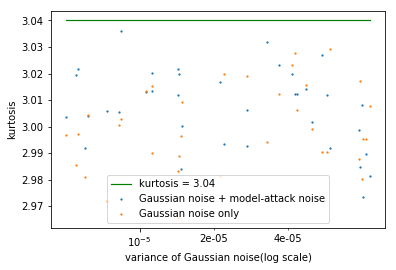

In [276]:
# Plot the curves separately for variance values between 1e-6 and 1e-5. The goal is to be able to identify 
# a clear threshold for the kurtosis value.
varListZ = []
b2FNvalsZ = []
b2FPvalsZ = []
for idx, val in enumerate(varList):
    if val >= 5e-6 and val <= 2e-4:
        varListZ.append(val)
        b2FNvalsZ.append(b2FNvals[idx])
        b2FPvalsZ.append(b2FPvals[idx])
fig, ax = plt.subplots()
plt.xscale('log')
ax.scatter(varListZ, b2FNvalsZ, s=1.5, label='Gaussian noise + model-attack noise')
ax.scatter(varListZ, b2FPvalsZ, s=1.5, label='Gaussian noise only')
ax.plot(varListZ, [3.04]*len(varListZ), 'g', linewidth=1.2, label = 'kurtosis = 3.04')
plt.xlabel('variance of Gaussian noise(log scale)')
plt.ylabel('kurtosis')
# ax.xaxis.set_major_locator(plt.LogLocator(base=10, numticks=10))
ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0,subs=(0.2,0.4),numticks=12))
ax.xaxis.set_minor_formatter(plt.LogFormatter(minor_thresholds=(5,2)))
plt.legend()

(array([60.,  7.,  8.,  5.,  6.,  3.,  3.,  4.,  3.,  6.]),
 array([4.43650902e-05, 9.66347198e-04, 1.88832931e-03, 2.81031141e-03,
        3.73229352e-03, 4.65427563e-03, 5.57625774e-03, 6.49823985e-03,
        7.42022196e-03, 8.34220406e-03, 9.26418617e-03]),
 <a list of 10 Patch objects>)

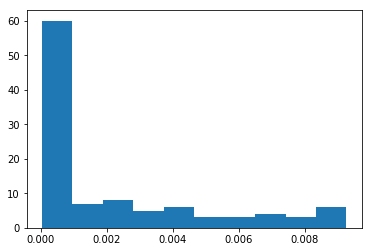

In [277]:
plt.hist(sigmaArray)